In [2]:
import pandas as pd
import numpy as np
import networkx as nx

import spacy
from spacy import displacy

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import os

import spacy
from spacy import displacy

import matplotlib.pyplot as plt

In [3]:
rfaSet = 'Data/wiki_RfA_2010_2013.csv'

#### Making DAT time Objects

In [4]:

# Read the CSV file
df = pd.read_csv(rfaSet)

# Convert 'DAT' to datetime, coercing errors to NaT (invalid datetimes)
df['DAT'] = pd.to_datetime(df['DAT'], format='%H:%M, %d %B %Y', errors='coerce')

na_count = df['DAT'].isna().sum()
print(f"Number of rows with NA in DAT: {na_count}")

# Remove rows where DAT is NaT (missing or invalid datetime)
df_cleaned = df.dropna(subset=['DAT'])


na_count = df_cleaned['DAT'].isna().sum()
print(f"Number of rows with NA in DAT: {na_count}")

# Print the cleaned dataframe
df_cleaned


Number of rows with NA in DAT: 262
Number of rows with NA in DAT: 0


,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
32567,Atama,ZooPro,-1,-1,2010,2010-02-22 18:17:00,"'''Oppose''' - Per Polargeo, and per [http://e..."
32568,Bradjamesbrown,ZooPro,-1,-1,2010,2010-02-22 18:18:00,'''Oppose''' per SilkTork's diff above. Assert...
32569,Ottawa4ever,ZooPro,0,-1,2010,2010-02-22 18:11:00,"'''Neutral''' Not to pile on, neutral. I canno..."
32570,Tryptofish,ZooPro,0,-1,2010,2010-02-22 17:58:00,'''Neutral''' I've interacted with this editor...


In [5]:

# Assuming df is the DataFrame that you've already filtered and processed
# Create a signed graph
def create_signed_graph(df):
    G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple edges between nodes
    
    # Iterate through the rows of the DataFrame to add edges and nodes
    for _, row in df.iterrows():
        src = row['SRC']
        tgt = row['TGT']
        vot = row['VOT']
        txt = row['TXT']  # Assuming there's a TXT column in the dataframe
        res = row['RES']  # Assuming there's a RES column in the dataframe
        dat = row['DAT']  # Assuming there's a DAT column in the dataframe
        
        # Add nodes (only storing their names/IDs, no status)
        if src not in G:
            G.add_node(src)
        if tgt not in G:
            G.add_node(tgt)
        
        # Determine admin status (based on RES value)
        admin_status = "admin" if res == 1 else "nonAdmin"
        
        # Add edge with the necessary attributes: vote weight, text, admin status, and DAT
        edge_attrs = {
            'weight': vot, 
            'txt': txt,
            'admin': admin_status,
            'DAT': dat  # Adding the DAT value to the edge attributes
        }

        G.add_edge(src, tgt, **edge_attrs)
    
    return G


# Visualize the signed graph
def visualize_graph(G):
    # Drawing the graph
    pos = nx.spring_layout(G)  # Positioning for better visualization
    plt.figure(figsize=(12, 12))
    
    # Draw nodes, edges, and labels
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')
    
    # Draw edge labels for the weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title("Signed Graph of SRC -> TGT Votes")
    plt.show()



# Create the signed graph
G = create_signed_graph(df_cleaned)
G.number_of_edges()

32310

In [28]:
G.number_of_edges()

len([node for node, degree in G.degree() if degree >= 10])

len(G.nodes())

G['Steel1943']['BDD'][0]['weight'] * 2

2

In [7]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh

def preprocess_graph(G):
    """
    Convert the graph to undirected and sum weights of multiple edges between nodes.
    
    Parameters:
        G (nx.MultiDiGraph): The input directed or undirected graph.
    
    Returns:
        nx.Graph: The undirected graph with summed weights for multiple edges.
    """
    # Convert to undirected graph if it's directed
    G = nx.to_undirected(G)
    
    # Create a new graph to store the summed weights
    new_G = nx.Graph()  # Undirected graph to store the summed weights
    
    # Iterate over all edges and sum the weights of multiple edges between the same pair of nodes
    for u, v, data in G.edges(data=True):
        weight = data['weight']
        
        if new_G.has_edge(u, v):
            # If the edge already exists, add the weight to the existing one
            new_G[u][v]['weight'] += weight
        else:
            # If the edge doesn't exist, create it with the current weight
            new_G.add_edge(u, v, weight=weight)
    
    return new_G

def signed_laplacian_matrix(G):
    """
    Computes the signed Laplacian matrix for a signed graph G.
    """
    # Adjacency matrix
    A = nx.adjacency_matrix(G).toarray()
    
    # Degree matrix (absolute weights for signed graphs)
    D = np.diag(np.sum(A, axis=1))
    
    # Signed Laplacian
    L = D - A
    return L

def unsigned_laplacian_matrix(G):
    A = nx.adjacency_matrix(G).toarray()  # Adjacency matrix
    D = np.diag(np.sum(np.abs(A), axis=1))  # Degree matrix (absolute values)
    L = D - A  # Unsigned Laplacian
    return L

def signed_spectral_clustering(G, k):
    """
    Perform signed spectral clustering.
    
    Parameters:
        G (nx.Graph): The signed graph.
        k (int): Number of clusters.
        
    Returns:
        labels (list): Cluster labels for nodes.
    """
    
    # Preprocess the graph to make it undirected and sum multiple edges
    G = preprocess_graph(G)
    
    # Check and remove isolated nodes
    isolates = list(nx.isolates(G))
    if isolates:
        print(f"Removing isolated nodes: {isolates}")
        G.remove_nodes_from(isolates)
    
    # Compute the signed Laplacian
    L = signed_laplacian_matrix(G)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Use the eigenvectors corresponding to the smallest k eigenvalues
    X = eigenvectors[:, :k]
    
    # Normalize rows of X
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    X = X / norms
    
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    return labels

def unsigned_spectral_clustering(G, k=2):
    # Step 1: Preprocess the graph
    G = preprocess_graph(G)

    # Step 2: Compute the Laplacian matrix
    L = unsigned_laplacian_matrix(G)
    
    # Step 3: Compute the eigenvalues and eigenvectors of the Laplacian
    # We use 'eigsh' which is efficient for sparse matrices and large graphs
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Step 4: Normalize the eigenvectors (rows are normalized to unit length)
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)

    # Step 5: Perform k-means clustering on the eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(eigenvectors)
    return kmeans.labels_


cl_si =signed_spectral_clustering(G, 23)
cl_un = unsigned_spectral_clustering(G,34)

Elbow Method:


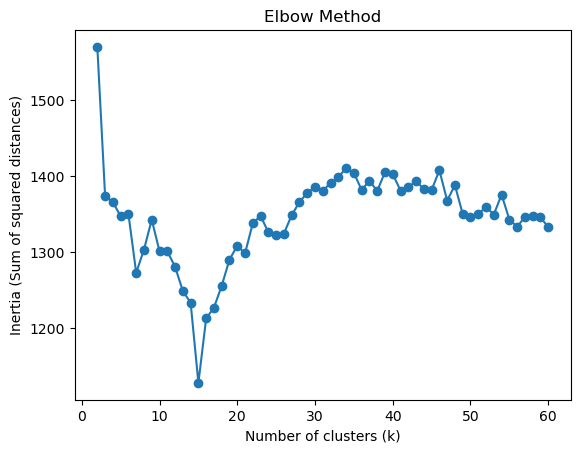


Silhouette Score Method:


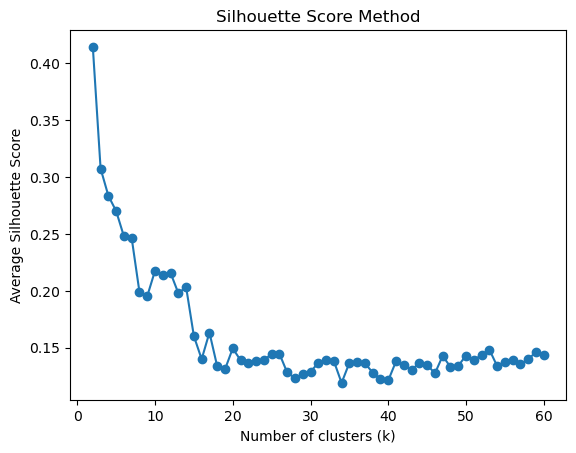

In [ ]:
from sklearn.metrics import silhouette_score



def compute_eigenvectors(G, k, signed= True):
    """
    Computes the eigenvectors for the signed Laplacian of the graph G.
    
    Parameters:
        G (nx.Graph): The signed graph.
        k (int): Number of eigenvectors to compute.
        
    Returns:
        X (np.ndarray): The eigenvectors corresponding to the smallest k eigenvalues.
    """
    G = preprocess_graph(G)
    
    # Compute the signed Laplacian
    if signed:
        L = signed_laplacian_matrix(G)
    else:
        L = unsigned_laplacian_matrix(G)
    
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Limit k to the number of nodes in the graph
    k = min(k, len(G.nodes))
    
    # Use the eigenvectors corresponding to the smallest k eigenvalues
    X = eigenvectors[:, :k]
    
    # Normalize rows of X
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1  # Avoid division by zero
    X = X / norms
    
    return X
    
def optimal_k(G, max_k=60, signed = True):
    """
    Find the optimal k using both the Elbow Method and Silhouette Score.
    
    Parameters:
        G (nx.Graph): The signed graph.
        max_k (int): Maximum number of clusters to check.
        
    Returns:
        None: Plots the Elbow and Silhouette score methods.
    """

    silhouette_avg = []
    inertia = []
    
    for k in range(2, max_k + 1):  # silhouette score requires at least 2 clusters
        # Compute the eigenvectors for the signed Laplacian
        X = compute_eigenvectors(G, k, signed)
        
        # Perform K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        
        # Calculate silhouette score
        silhouette_avg.append(silhouette_score(X, labels))
        inertia.append(kmeans.inertia_)
    
    # Plot the Elbow Method (Inertia)
    print("Elbow Method:")
    plt.plot(range(2, max_k + 1), inertia, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (Sum of squared distances)')
    plt.show()
    
    # Plot Silhouette Score Method
    print("\nSilhouette Score Method:")
    plt.plot(range(2, max_k + 1), silhouette_avg, marker='o')
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.show()

# Example usage
# Assuming G is your signed graph (directed or undirected)
optimal_k(G, signed = True)

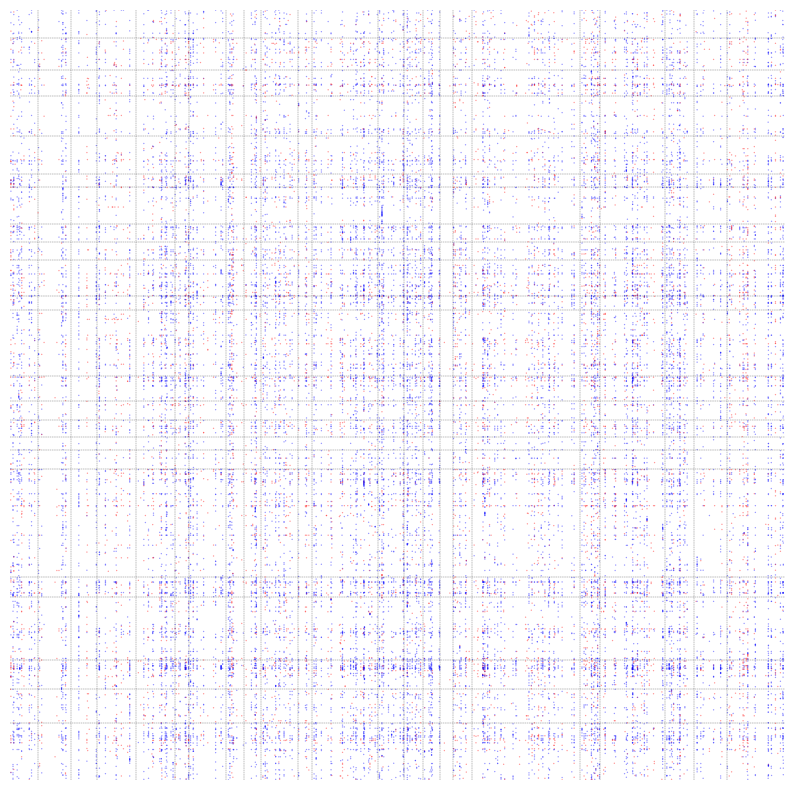

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

def rearrange_adjacency_matrix(G, cluster_labels):
    """
    Rearrange the adjacency matrix of a graph based on cluster labels.
    
    Parameters:
        G (nx.Graph): The graph.
        cluster_labels (list or np.ndarray): Cluster labels for each node.
    
    Returns:
        np.ndarray: The rearranged adjacency matrix.
        np.ndarray: The new order of node indices.
    """
    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    
    # Get sorted node indices based on cluster labels
    sorted_indices = np.argsort(cluster_labels)
    
    # Rearrange rows and columns of the adjacency matrix
    rearranged_matrix = adjacency_matrix[np.ix_(sorted_indices, sorted_indices)]
    
    return rearranged_matrix, sorted_indices

def compute_adjacency_matrix(G):
    """
    Compute the adjacency matrix for the signed graph G.
    
    Parameters:
        G (nx.Graph): The signed graph.
        
    Returns:
        adj_matrix (np.ndarray): The adjacency matrix of the graph.
    """
    return nx.to_numpy_array(G)

def plot_adjacency_matrix_with_dots(G, labels):
    """
    Plots the adjacency matrix sorted by clusters and shows individual connections as dots.
    
    Parameters:
        G (nx.Graph): The signed graph.
        labels (list): Cluster labels for each node.
        
    Returns:
        None: Displays the heatmap plot with dots showing individual connections.
    """
    # Rearrange adjacency matrix
    adj_matrix, sorted_indices = rearrange_adjacency_matrix(G, labels)
    
    # Sort labels
    sorted_labels = np.array(labels)[sorted_indices]
    
    # Plot the adjacency matrix as a heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(adj_matrix, cmap='coolwarm', cbar=False, linewidths=0.5, annot=False)
    
    # Overlay individual connections (edges) as dots
    for i in range(len(G.nodes())):
        for j in range(len(G.nodes())):
            if adj_matrix[i, j] != 0:  # Only plot non-zero edges
                if adj_matrix[i, j] > 0:  # Positive edge
                    plt.scatter(j + 0.5, i + 0.5, color='b', s=1, edgecolors='none', alpha=0.4)
                elif adj_matrix[i, j] < 0:  # Negative edge
                    plt.scatter(j + 0.5, i + 0.5, color='r', s=1, edgecolors='none', alpha=0.4)
    
    # Add vertical and horizontal lines at cluster boundaries
    cluster_boundaries = np.where(np.diff(sorted_labels))[0] + 1
    for boundary in cluster_boundaries:
        plt.axvline(x=boundary, color='black', linestyle='--', linewidth=0.3, alpha=0.6)
        plt.axhline(y=boundary, color='black', linestyle='--', linewidth=0.3, alpha=0.6)
    
    # Remove axis labels and ticks
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

def plot_clusters(G, cluster_labels):
    """
    Plot the adjacency matrix with clusters already determined, showing individual connections.
    
    Parameters:
        G (nx.Graph): The signed graph.
        cluster_labels (list): The cluster labels for each node.
        
    Returns:
        None: Displays the plot.
    """
    plot_adjacency_matrix_with_dots(G, cluster_labels)

# Example usage
# Assuming G is your signed graph (directed or undirected)
# Assuming `labels` is the list of cluster labels you've already determined
# and `k` is the number of clusters you decided on.

# Use KMeans or any clustering method to assign labels if you haven't already

# Now plot the sorted adjacency matrix based on the clustering labels
plot_clusters(G, cluster_labels=cl_si)


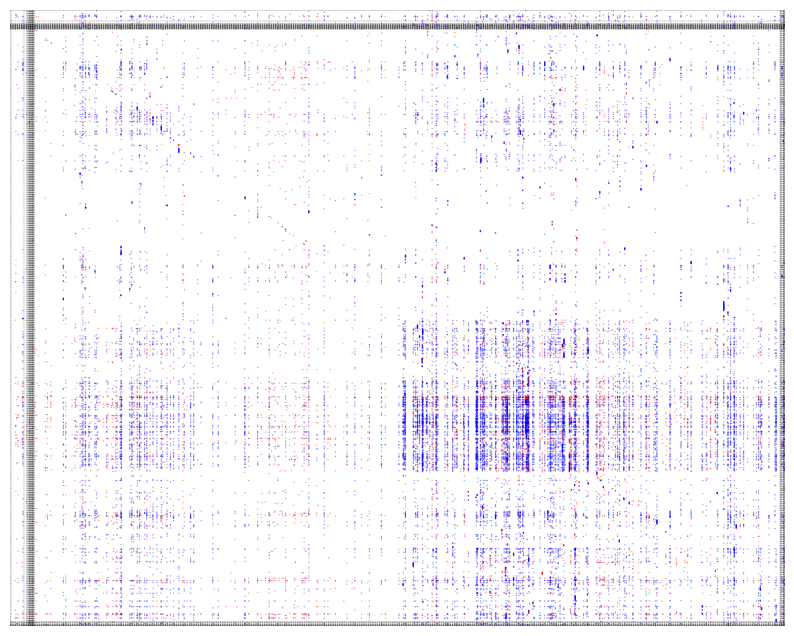

In [11]:
plot_clusters(G, cluster_labels=cl_un)

In [9]:
list(G.nodes)
len(cl_si)

2968

Elbow Method:


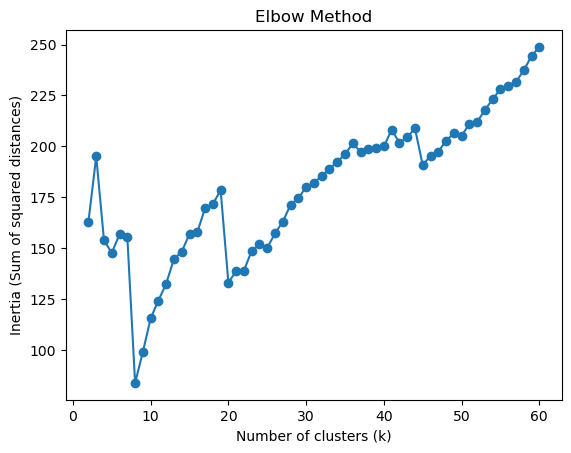


Silhouette Score Method:


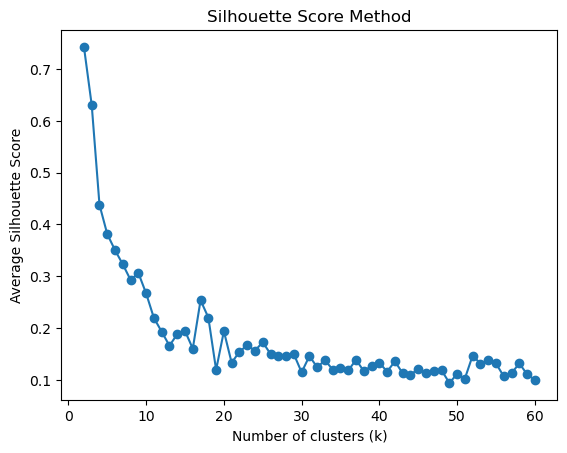

In [34]:
# Create a list of nodes with degree >= 10
nodes_to_keep = [node for node, degree in G.degree() if degree >= 10]

# Create a subgraph that only contains these nodes
G10 = G.subgraph(nodes_to_keep).copy()  # Use .copy() to ensure it's a separate graph

# Now, you can use G10 for further analysis
optimal_k(G10)

### GML Format to Gephi

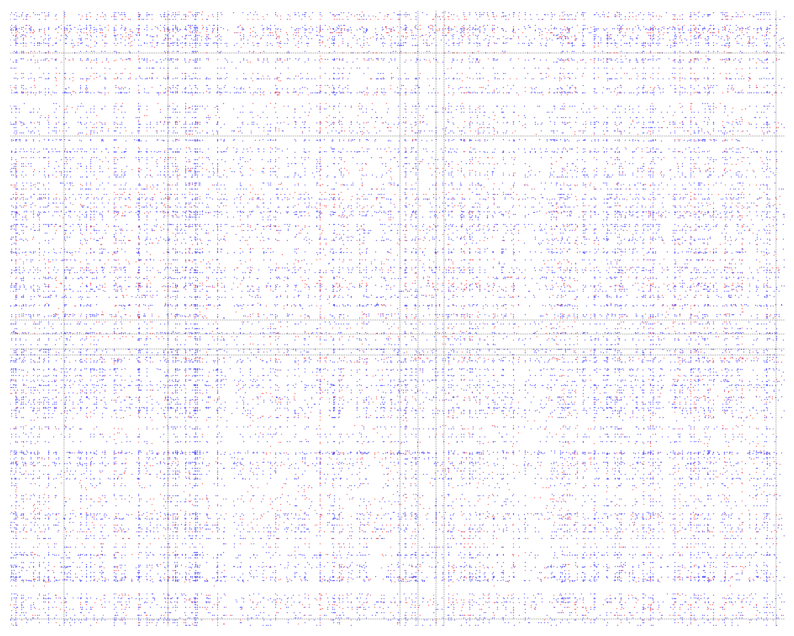

In [42]:
cl10 =signed_spectral_clustering(G10, 8)
plot_clusters(G10, cluster_labels=cl10)

### Graph Characteristics


In [ ]:
G = create_signed_graph(df)

number of nodes

In [ ]:
G.number_of_nodes()

2986

### Number of Admins and NonAdmins

In [ ]:
# Count the number of nodes with 'status' as 'admin'
admin_count = sum(1 for node, data in G.nodes(data=True) if data['status'] == 'admin')

print(f"Number of admin nodes: {admin_count}")


Number of admin nodes: 2238


In [ ]:
# Count the number of nodes with 'status' as 'nonAdmin'
non_admin_count = sum(1 for node, data in G.nodes(data=True) if data['status'] == 'nonAdmin')

print(f"Number of nonAdmin nodes: {non_admin_count}")



Number of nonAdmin nodes: 748


### Number of Edges

In [ ]:
G.number_of_edges()

31876

In [ ]:
# Get the first 10 edges' txt attributes
edge_txts = [data['txt'] for _, _, data in list(G.edges(data=True))[:10]]

# Print each txt value on a separate line
for txt in edge_txts:
    print()
    print(txt)



'''Support''' as co-nom.

<del>'''Neutral'''</del>. '''Moral Support'''. I've only run across RockMagnetist once in my travels in checking/editing articles on this Wikipedia, and RockMagnetist seems like a good candidate for this based on the description above. However, since I have to base my votes on the actual experience I have had with the user as an editor, I cannot sway my vote either way. Either way, I am leaning more towards a support, but since I vote based on interaction, I have neither any positive nor negative thoughts going through my head, so I vote "Neutral".

'''Neutral'''. As I vote based on actual interaction with an editor, since I have never interacted with this editor at all in the past, I have to vote "Neutral".

'''Oppose'''. Well, I was going to vote "Neutral" since I base my votes on interaction with the editor/user; however, after reading [[User:Reaper Eternal|Reaper Eternal]]'s opposition statement, I can definitely agree that I do not want an administrator 

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the data

# Group by 'TGT' and 'YEA' (year) and count the occurrences
target_years = df.groupby(['TGT', 'YEA']).size().reset_index(name='count')

# Now group by 'TGT' and get the list of distinct years each target appears in
target_years_list = target_years.groupby('TGT')['YEA'].apply(list)

# Filter for targets that appear in more than one year
targets_in_multiple_years = target_years_list[target_years_list.apply(len) > 1]

# Output the result
print("Targets that appear in multiple different years, with the years:")
print(targets_in_multiple_years)


Targets that appear in multiple different years, with the years:
TGT
28bytes               [2010, 2011]
Ankitbhatt            [2010, 2011]
Armbrust              [2010, 2011]
BuickCenturyDriver    [2010, 2011]
Calabe1992            [2011, 2012]
Curtis23              [2010, 2011]
DeltaQuad             [2010, 2011]
Dusti                 [2010, 2011]
Floydian              [2011, 2012]
GSorby                [2011, 2012]
GiantSnowman          [2011, 2012]
Guoguo12              [2010, 2011]
HJ Mitchell           [2010, 2011]
Hahc21                [2012, 2013]
Ironholds             [2010, 2011]
ItsZippy              [2011, 2012]
Ktr101                [2010, 2012]
Lord Roem             [2012, 2013]
Marcus Qwertyus       [2010, 2012]
My76Strat             [2011, 2012]
Rami R                [2010, 2011]
Reenem                [2010, 2011]
Rehman                [2010, 2011]
Richardcavell         [2010, 2011]
Richwales             [2010, 2011]
Secret                [2010, 2013]
Slon02               

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the data

# First, filter non-admins (RES = -1)
non_admins = df[df['RES'] == -1]

# Now filter admins (RES = 1)
admins = df[df['RES'] == 1]

# Merge both dataframes on 'SRC' to find non-admins that later become admins
merged = pd.merge(non_admins[['TGT', 'YEA']], admins[['TGT', 'YEA']], on='TGT', how='inner', suffixes=('_nonAdmin', '_admin'))

# Now, check if the admin year is later than the non-admin year
merged = merged[merged['YEA_admin'] > merged['YEA_nonAdmin']]

# Output the result
print("Non-admins that became admins in a later year:")
print(merged)


Non-admins that became admins in a later year:
              TGT  YEA_nonAdmin  YEA_admin
0       Lord Roem          2012       2013
1       Lord Roem          2012       2013
2       Lord Roem          2012       2013
3       Lord Roem          2012       2013
4       Lord Roem          2012       2013
...           ...           ...        ...
155752     Slon02          2010       2011
155753     Slon02          2010       2011
155754     Slon02          2010       2011
155755     Slon02          2010       2011
155756     Slon02          2010       2011

[101053 rows x 3 columns]


In [30]:
def edge_vote_percentages(G):
    """
    Calculate the percentage of edges in the graph for each VOT value.

    Parameters:
        G (nx.MultiGraph): Input MultiGraph with 'VOT' attributes.

    Returns:
        dict: A dictionary where keys are VOT values, and values are percentages.
    """
    vote_counts = {}
    total_edges = G.number_of_edges()

    if total_edges == 0:
        return {}  # Handle case of no edges

    # Count edges by VOT
    for _, _, data in G.edges(data=True):
        vot_value = data.get('VOT', 0)
        vote_counts[vot_value] = vote_counts.get(vot_value, 0) + 1

    # Calculate percentages
    vote_percentages = {
        vot: (count / total_edges) * 100 for vot, count in vote_counts.items()
    }
    return vote_percentages

edge_vote_percentages(G)

{0: 100.0}

In [39]:
def has_cycle_with_negative_edge(G):
    """
    Check if any cycle in the graph contains at least one edge with a negative sign.

    Parameters:
        G (nx.MultiGraph): Input MultiGraph with 'sign' attributes.

    Returns:
        bool: True if there is a cycle with at least one negative edge, False otherwise.
    """
    # Find all cycles in the graph
    cycles = find_all_cycles_multigraph(G)
    if not cycles:
        return False  # No cycles in the graph

    for cycle in cycles:
        for i in range(len(cycle)):
            u = cycle[i]
            v = cycle[(i + 1) % len(cycle)]  # Wrap around to form a cycle
            edge_data = G.get_edge_data(u, v)
            if edge_data:  # Check each parallel edge
                for _, data in edge_data.items():
                    if data.get('sign', 1) < 0:  # Negative sign found
                        return True
    return False

has_cycle_with_negative_edge(G)

def has_negative_edges(G):
    """
    Check if the graph has any edges with a negative sign.

    Parameters:
        G (nx.MultiGraph): Input MultiGraph with 'sign' attributes.

    Returns:
        bool: True if there is at least one edge with a negative sign, False otherwise.
    """
    for u, v, edge_data in G.edges(data=True):
        if edge_data.get('sign', 1) < 0:  # Negative sign found
            return True
    return False

has_negative_edges(G)

NameError: name 'find_all_cycles_multigraph' is not defined

In [51]:
G = create_signed_graph(df_cleaned)
def graph_balance_score(G):
    """
    Analyze the balance of a MultiDiGraph by checking cycle balance,
    treating edges with weight == 0 as positive.

    Parameters:
        G (nx.MultiDiGraph): Input MultiDiGraph with 'weight' attributes for signs.

    Returns:
        float: Balance score (ratio of balanced cycles to total cycles).
        int: Number of balanced cycles.
        int: Total number of cycles.
    """
    # Find all cycles in the graph
    cycles = find_all_cycles_multigraph(G)
    if not cycles:
        return 1.0, 0, 0  # No cycles => perfectly balanced

    balanced_cycles = 0
    for cycle in cycles:
        sign_product = 1
        for i in range(len(cycle)):
            u = cycle[i]
            v = cycle[(i + 1) % len(cycle)]  # Wrap around
            # Get all parallel edges and multiply their weights (interpreted as signs)
            edge_data = G.get_edge_data(u, v)
            if edge_data:  # Process only if there are edges
                for _, data in edge_data.items():
                    vot_value = data.get('weight', 0)  # Default to 0 if no weight
                    edge_sign = 1 if vot_value >= 0 else -1
                    sign_product *= edge_sign

        if sign_product > 0:
            balanced_cycles += 1

    total_cycles = len(cycles)
    balance_score = balanced_cycles / total_cycles
    return balance_score, balanced_cycles, total_cycles

score, balanced, total = graph_balance_score(remove_neutral_edges(G))
print(f"Balance Score: {score:.2f} ({balanced}/{total} cycles are balanced)")

Balance Score: 1.00 (0/0 cycles are balanced)


In [ ]:
G = create_signed_graph(df_cleaned)
def multigraph_to_graph_with_vote_product(G):
    new_graph = nx.DiGraph()  # Using a DiGraph here, change to MultiGraph if needed
    for u, v in G.edges():
        # Collect all 'weight' attributes for edges between u and v
        edge_data = G[u][v]  # Access the multiple edges between u and v
        vote_product = 1  # Initialize the product to 1
        has_non_zero = False  # Flag to track if any non-zero votes are present
        all_zero = True  # Flag to check if all votes are zero
        
        # Iterate over all the edges between u and v
        for key, data in edge_data.items():
            weight = data['weight']
            if weight != 0:
                vote_product *= weight  # Multiply only non-zero votes
                has_non_zero = True
            if weight != 0:
                all_zero = False

        # If there were no non-zero weights, set vote_product to 0
        if not has_non_zero:
            vote_product = 0
        
        # Add the edge with the calculated vote product as an attribute
        new_graph.add_edge(u, v, weight=vote_product)

    return new_graph


def graph_balance_score(graph, max_cycle_length=5, max_sample=10):
    """
    Calculate the balance score of a graph based on its cycles.
    
    Parameters:
    - graph: NetworkX DiGraph or Graph.
    - max_cycle_length: Maximum length of cycles to consider (None for no limit).
    - max_sample: Maximum number of cycles to process for balance.
    
    Returns:
    - balance_score: Fraction of balanced cycles.
    - balanced_cycles: Count of balanced cycles.
    - total_cycles: Total number of cycles considered.
    """
    import random
    from networkx import simple_cycles, cycle_basis

    # Determine if the graph is directed or undirected
    if graph.is_directed():
        # Get all simple cycles (directed cycles)
        cycles = list(simple_cycles(graph))
    else:
        # Get undirected cycles using cycle_basis
        cycles = cycle_basis(graph.to_undirected())

    # Apply cycle length filtering if specified
    if max_cycle_length is not None:
        cycles = [cycle for cycle in cycles if len(cycle) <= max_cycle_length]

    # Apply sampling if too many cycles
    if len(cycles) > max_sample:
        cycles = random.sample(cycles, max_sample)

    total_cycles = len(cycles)
    balanced_cycles = 0

    # Process each cycle
    for cycle in cycles:
        # Extract edges in the cycle
        edges = [(cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))]
        product = 1

        # Compute product of edge weights
        for u, v in edges:
            if graph.has_edge(u, v):
                # Handle MultiGraph or MultiDiGraph by summing or averaging weights
                if isinstance(graph, (nx.MultiGraph, nx.MultiDiGraph)):
                    product *= sum([data['weight'] for key, data in graph[u][v].items()])
                else:
                    product *= graph[u][v]['weight']

        # Check balance
        if product > 0:
            balanced_cycles += 1

    # Calculate balance score
    balance_score = balanced_cycles / total_cycles if total_cycles > 0 else 0

    return balance_score, balanced_cycles, total_cycles

len(multigraph_to_graph_with_vote_product(G).edges())
len(nx.cycle_basis(multigraph_to_graph_with_vote_product(G).to_undirected()))
graph_balance_score(multigraph_to_graph_with_vote_product(G))


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10d9e3ef0>>
Traceback (most recent call last):
  File "/Users/helenamaki/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [43]:
simple_cycles(G)

NameError: name 'simple_cycles' is not defined

In [51]:
import random
def sample_triads(graph, num_samples=100):
    """
    Sample triads in the graph by randomly picking nodes and their neighbors.
    
    :param graph: The graph object (NetworkX graph)
    :param num_samples: The number of triads to sample
    :return: List of sampled triads
    """
    triads = []
    sampled_triads = 0

    while sampled_triads < num_samples:
        # Randomly pick a node
        u = random.choice(list(graph.nodes()))
        
        # Get neighbors of u
        neighbors_u = list(graph.neighbors(u))
        if len(neighbors_u) < 2:
            continue  # Skip nodes with less than 2 neighbors (cannot form a triad)
        
        # Randomly pick two neighbors to form a potential triad
        v, w = random.sample(neighbors_u, 2)
        
        # Check if there's an edge between v and w to complete the triad
        if graph.has_edge(v, w):
            triads.append((u, v, w))
            sampled_triads += 1

    return triads


def evaluate_balance_of_triads(graph, num_samples=1000):
    """
    Evaluate balance of sampled triads in the graph.
    
    :param graph: The graph to analyze.
    :param num_samples: The number of random triads to sample for balance evaluation.
    :return: Balance score (ratio of balanced triads to total sampled triads).
    """
    
    def get_weight(u, v):
        """Get the weight of the edge between nodes u and v."""
        if u in graph and v in graph[u]:
            for edge_key in graph[u][v]:
                if 'weight' in graph[u][v][edge_key]:
                    return graph[u][v][edge_key]['weight']
        return None  # Return None if weight does not exist
    
    def is_balanced(edges):
        """Determine if a set of edges forms a balanced triad."""
        # Balance condition: Two positive edges and one negative, or all positive edges
        if edges is None:  # If any edge is missing or has weight 0, skip this triad
            return False
        # Check if at least two edges are positive (weight > 0)
        return edges.count(1) >= 2
    
    # Sample triads randomly
    triads = []
    sampled_triads = 0
    while sampled_triads < num_samples:
        # Randomly pick a node
        u = random.choice(list(graph.nodes()))
        
        # Get neighbors of u
        neighbors_u = list(graph.neighbors(u))
        
        # Find pairs of neighbors to form a triad
        for v in neighbors_u:
            for w in neighbors_u:
                if v != w and graph.has_edge(u, v) and graph.has_edge(v, w) and graph.has_edge(w, u):
                    triads.append((u, v, w))
                    sampled_triads += 1
                    break  # To ensure we don't sample too many
        
    balanced_triads = 0
    for triad in triads:
        u, v, w = triad
        # Get edge weights for the triad edges (avoid 0 weight)
        edges = [
            get_weight(u, v),  # Edge between u and v
            get_weight(v, w),  # Edge between v and w
            get_weight(w, u)   # Edge between w and u
        ]
        
        # Skip triads with any zero-weight edge
        if None in edges or 0 in edges:
            continue
        
        # Check if the triad is balanced
        if is_balanced(edges):
            balanced_triads += 1
    
    # Calculate balance score (ratio of balanced triads to total triads)
    balance_score = balanced_triads / len(triads) if triads else 0
    return balance_score, balanced_triads, len(triads)



evaluate_balance_of_triads(G, num_samples=10000)

(0.7925298804780877, 7957, 10040)

In [ ]:
# CORRECT CALCULATION  OF TRIADS THIS ONE THIS ONE THIS ONE 

def evaluate_balance_of_triads(graph):
    """
    Evaluate balance of all triads in the graph.
    
    :param graph: The graph to analyze.
    :return: Balance score (ratio of balanced triads to total triads).
    """
    
    def get_weight(u, v):
        """Get the weight of the edge between nodes u and v."""
        if u in graph and v in graph[u]:
            for edge_key in graph[u][v]:
                if 'weight' in graph[u][v][edge_key]:
                    return graph[u][v][edge_key]['weight']
        return None  # Return None if weight does not exist
    
    def is_balanced(edges):
        """Determine if a set of edges forms a balanced triad."""
        # Balance condition: Two positive edges and one negative, or all positive edges
        if edges is None:  # If any edge is missing or has weight 0, skip this triad
            return False
        # Check if at least two edges are positive (weight > 0)
        return edges.count(1) >= 2
    
    balanced_triads = 0
    total_triads = 0
    
    # Iterate over all possible triads in the graph
    for u in graph.nodes():
        neighbors_u = list(graph.neighbors(u))
        for v in neighbors_u:
            for w in neighbors_u:
                if v != w and graph.has_edge(u, v) and graph.has_edge(v, w) and graph.has_edge(w, u):
                    total_triads += 1
                    
                    # Get edge weights for the triad edges (avoid 0 weight)
                    edges = [
                        get_weight(u, v),  # Edge between u and v
                        get_weight(v, w),  # Edge between v and w
                        get_weight(w, u)   # Edge between w and u
                    ]
                    
                    # Skip triads with any zero-weight edge
                    if None in edges or 0 in edges:
                        continue
                    
                    # Check if the triad is balanced
                    if is_balanced(edges):
                        balanced_triads += 1
    
    # Calculate balance score (ratio of balanced triads to total triads)
    balance_score = balanced_triads / total_triads if total_triads > 0 else 0
    return balance_score, balanced_triads, total_triads

# Example usage:
evaluate_balance_of_triads(G)

(0.8018613173883692, 16629, 20738)

In [54]:
import networkx as nx

def evaluate_balance_of_cycles(graph):
    """
    Evaluate balance of all cycles in the graph.
    
    :param graph: The graph to analyze.
    :return: Balance score (ratio of balanced cycles to total cycles).
    """
    
    def get_weight(u, v):
        """Get the weight of the edge between nodes u and v."""
        if u in graph and v in graph[u]:
            for edge_key in graph[u][v]:
                if 'weight' in graph[u][v][edge_key]:
                    return graph[u][v][edge_key]['weight']
        return None  # Return None if weight does not exist
    
    def is_balanced(edges):
        """Determine if a set of edges forms a balanced cycle."""
        # Balance condition: Two positive edges and one negative, or all positive edges
        if edges is None:  # If any edge is missing or has weight 0, skip this cycle
            return False
        # Check if at least two edges are positive (weight > 0)
        return edges.count(1) >= 2
    
    balanced_cycles = 0
    total_cycles = 0
    
    # Find all simple cycles in the graph
    cycles = list(nx.simple_cycles(graph))
    
    # Iterate over all cycles in the graph
    for cycle in cycles:
        total_cycles += 1
        
        # Get edge weights for the cycle edges (avoid 0 weight)
        edges = []
        for i in range(len(cycle)):
            u = cycle[i]
            v = cycle[(i + 1) % len(cycle)]  # The next node in the cycle (wrapping around)
            
            # Get the weight for the edge u -> v
            weight = get_weight(u, v)
            edges.append(weight)
        
        # Skip cycles with any zero-weight edge
        if None in edges or 0 in edges:
            continue
        
        # Check if the cycle is balanced
        if is_balanced(edges):
            balanced_cycles += 1
    
    # Calculate balance score (ratio of balanced cycles to total cycles)
    balance_score = balanced_cycles / total_cycles if total_cycles > 0 else 0
    return balance_score, balanced_cycles, total_cycles

# Example usage:
evaluate_balance_of_cycles(G)

KeyboardInterrupt: 

In [40]:
G = create_signed_graph(df_cleaned)
def multigraph_to_graph_with_vote_product(G):
    new_graph = nx.DiGraph()  # Using a DiGraph here, change to MultiGraph if needed
    for u, v in G.edges():
        # Collect all 'weight' attributes for edges between u and v
        edge_data = G[u][v]  # Access the multiple edges between u and v
        vote_product = 1  # Initialize the product to 1
        has_non_zero = False  # Flag to track if any non-zero votes are present
        all_zero = True  # Flag to check if all votes are zero
        
        # Iterate over all the edges between u and v
        for key, data in edge_data.items():
            weight = data['weight']
            if weight != 0:
                vote_product *= weight  # Multiply only non-zero votes
                has_non_zero = True
            if weight != 0:
                all_zero = False

        # If there were no non-zero weights, set vote_product to 0
        if not has_non_zero:
            vote_product = 0
        
        # Add the edge with the calculated vote product as an attribute
        new_graph.add_edge(u, v, weight=vote_product)

    return new_graph
def triad_balance_score(graph):
    """
    Calculate balance score based on triads (3-cycles) in the graph.
    
    Parameters:
    - graph: NetworkX DiGraph or Graph.
    
    Returns:
    - balance_score: Fraction of balanced triads.
    - balanced_triads: Count of balanced triads.
    - total_triads: Total number of triads considered.
    """
    from itertools import combinations

    balanced_triads = 0
    total_triads = 0

    # Function to safely get the weight of an edge (using only the 0th edge)
    def get_weight(u, v):
        # Get the first edge (0th) between u and v
        if graph.has_edge(u, v):
            edge_data = graph[u][v][0]  # Use the 0th edge
            return edge_data.get('weight', 1)  # Return the weight or 1 if it's missing
        return 1  # Default weight if no edge exists

    # For directed graphs, consider ordered triplets
    if graph.is_directed():
        nodes = list(graph.nodes())
        for u, v, w in combinations(nodes, 3):
            if graph.has_edge(u, v) and graph.has_edge(v, w) and graph.has_edge(w, u):
                total_triads += 1
                # Compute product of edge weights for the triad (u, v, w)
                product = (get_weight(u, v) *
                           get_weight(v, w) *
                           get_weight(w, u))
                if product > 0:
                    balanced_triads += 1

    # For undirected graphs, consider unordered triplets
    else:
        for u, v, w in combinations(graph.nodes(), 3):
            if graph.has_edge(u, v) and graph.has_edge(v, w) and graph.has_edge(w, u):
                total_triads += 1
                # Compute product of edge weights for the triad (u, v, w)
                product = (get_weight(u, v) *
                           get_weight(v, w) *
                           get_weight(w, u))
                if product > 0:
                    balanced_triads += 1

    # Calculate balance score
    balance_score = balanced_triads / total_triads if total_triads > 0 else 0

    return balance_score, balanced_triads, total_triads


triad_balance_score(G)

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt

def calculate_status(graph):
    """
    Calculate status for each node based on generative and receptive baselines.
    
    :param graph: Directed signed graph with 'weight' attribute (+1/-1).
    :return: Dictionary with status information for each node.
    """
    generative_baseline = {}
    receptive_baseline = {}
    status = {}

    # Step 1: Compute baselines
    for node in graph.nodes():
        out_edges = graph.out_edges(node, data=True)
        in_edges = graph.in_edges(node, data=True)

        # Generative baseline: Fraction of positive outgoing edges
        positive_out = sum(1 for _, _, attr in out_edges if attr.get('weight', 0) > 0)
        total_out = len(out_edges)
        generative_baseline[node] = positive_out / total_out if total_out > 0 else 0

        # Receptive baseline: Fraction of positive incoming edges
        positive_in = sum(1 for _, _, attr in in_edges if attr.get('weight', 0) > 0)
        total_in = len(in_edges)
        receptive_baseline[node] = positive_in / total_in if total_in > 0 else 0

    # Step 2: Compute status for each node
    for node in graph.nodes():
        status[node] = {"generative": 0, "receptive": 0}
        #print(status[node])

        # Outgoing edges: Generative surprise
        for _, target, attr in graph.out_edges(node, data=True):
            weight = attr.get('weight', 0)
            gen_surprise = weight - generative_baseline[node]
            status[node]["generative"] += gen_surprise

        # Incoming edges: Receptive surprise
        for source, _, attr in graph.in_edges(node, data=True):
            weight = attr.get('weight', 0)
            rec_surprise = weight - receptive_baseline[node]
            status[node]["receptive"] += rec_surprise
    print(len(status))
    print(sum(status))
    return status


def plot_status(graph, status):
    """
    Visualize the graph with node status represented by color and size.
    """
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    
    pos = nx.spring_layout(graph)
    node_colors = [status[node]["generative"] + status[node]["receptive"] for node in graph.nodes()]
    node_sizes = [300 + 1000 * abs(status[node]["generative"] + status[node]["receptive"]) for node in graph.nodes()]
    
    # Normalize the node colors for the colormap
    norm = colors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    cmap = plt.cm.coolwarm
    
    plt.figure(figsize=(10, 10))
    nx.draw(
        graph, pos, with_labels=True, node_color=node_colors,
        node_size=node_sizes, cmap=cmap, edge_color="gray"
    )
    # Add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label="Status")
    
    plt.title("Node Status Visualization")
    plt.show()



# Example Usage
status_results = calculate_status(G)  # G is your directed signed graph
plot_status_distribution_lines(status_results)

2968


TypeError: unsupported operand type(s) for +: 'int' and 'str'

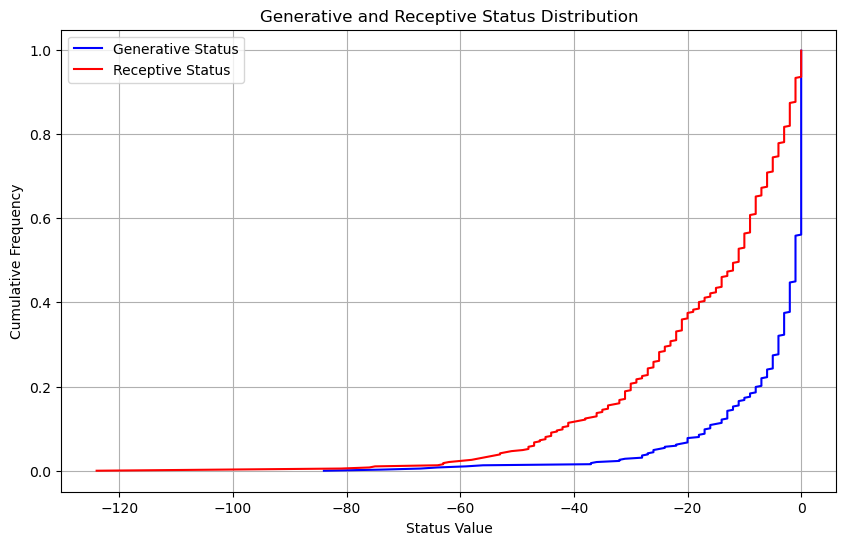

In [28]:
import matplotlib.pyplot as plt

def calculate_status(graph):
    """
    Calculate status for each node based on generative and receptive baselines.
    
    :param graph: Directed signed graph with 'weight' attribute (+1/-1).
    :return: Dictionary with status information for each node.
    """
    generative_baseline = {}
    receptive_baseline = {}
    status = {}

    # Step 1: Compute baselines
    for node in graph.nodes():
        out_edges = graph.out_edges(node, data=True)
        in_edges = graph.in_edges(node, data=True)

        # Generative baseline: Fraction of positive outgoing edges
        positive_out = sum(1 for _, _, attr in out_edges if attr.get('weight', 0) > 0)
        total_out = len(out_edges)
        generative_baseline[node] = positive_out / total_out if total_out > 0 else 0

        # Receptive baseline: Fraction of positive incoming edges
        positive_in = sum(1 for _, _, attr in in_edges if attr.get('weight', 0) > 0)
        total_in = len(in_edges)
        receptive_baseline[node] = positive_in / total_in if total_in > 0 else 0

    # Step 2: Compute status for each node, skip nodes with no incoming edges or only negative incoming edges
    for node in graph.nodes():
        # Skip nodes with no incoming edges
        if len(list(graph.in_edges(node))) == 0:
            continue

        # Skip nodes that only have negative incoming edges
        incoming_weights = [attr['weight'] for _, _, attr in graph.in_edges(node, data=True)]
        if all(weight < 0 for weight in incoming_weights):  # Only negative incoming edges
            continue

        status[node] = {"generative": 0, "receptive": 0}
        
        # Outgoing edges: Generative surprise
        for _, target, attr in graph.out_edges(node, data=True):
            weight = attr.get('weight', 0)
            gen_surprise = weight - generative_baseline[node]
            status[node]["generative"] += gen_surprise

        # Incoming edges: Receptive surprise
        for source, _, attr in graph.in_edges(node, data=True):
            weight = attr.get('weight', 0)
            rec_surprise = weight - receptive_baseline[node]
            status[node]["receptive"] += rec_surprise

    return status



def plot_status_distribution_lines(status):
    """
    Plot the distribution of generative and receptive status values as two lines.
    
    :param status: Dictionary of node statuses with generative and receptive scores.
    """
    # Extract generative and receptive status values
    generative_values = [status[node]["generative"] for node in status]
    receptive_values = [status[node]["receptive"] for node in status]

    # Plot the distributions as lines
    plt.figure(figsize=(10, 6))
    
    # Generative status distribution
    plt.plot(sorted(generative_values), [i / len(generative_values) for i in range(len(generative_values))], label='Generative Status', color='blue')
    
    # Receptive status distribution
    plt.plot(sorted(receptive_values), [i / len(receptive_values) for i in range(len(receptive_values))], label='Receptive Status', color='red')
    
    # Adding labels and title
    plt.title('Generative and Receptive Status Distribution')
    plt.xlabel('Status Value')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example Usage:

status_results = calculate_status(G)
plot_status_distribution_lines(status_results)

In [47]:
import networkx as nx

def calculate_edge_counts(graph):
    """
    Count the number of positive, negative, and neutral edges in the graph.
    
    :param graph: NetworkX graph with 'weight' attribute (+1/-1/0).
    :return: A tuple of (positive_count, negative_count, neutral_count).
    """
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    
    # Loop through all edges in the graph and count the number of positive, negative, and neutral edges
    for u, v, attr in graph.edges(data=True):
        weight = attr.get('weight', 0)
        if weight > 0:
            positive_count += 1
        elif weight < 0:
            negative_count += 1
        else:
            neutral_count += 1
    
    return positive_count, negative_count, neutral_count

def calculate_balanced_triads_probability(graph):
    """
    Calculate the probability of a balanced triad assuming neutral edges count as positive.
    
    :param graph: NetworkX graph with 'weight' attribute (+1/-1/0).
    :return: Probability of a balanced triad.
    """
    positive_count, negative_count, neutral_count = calculate_edge_counts(graph)
    
    # Neutral edges count as positive
    positive_count += neutral_count
    
    # Total number of edges in the graph
    total_edges = positive_count + negative_count
    
    # Calculate the probabilities
    p_positive = positive_count / total_edges
    p_negative = negative_count / total_edges
    
    # Calculate the probability of a balanced triad
    # Balanced triad conditions:
    # 1. Two positive edges and one negative edge
    # 2. All three edges are positive
    
    # Probability of balanced triad (assuming random edge assignment)
    p_balanced = (p_positive**3) + (3 * p_positive**2 * p_negative)
    
    return p_balanced

# Calculate the probability of a balanced triad
probability = calculate_balanced_triads_probability(G)
print(f"Probability of a balanced triad: {probability}")


Probability of a balanced triad: 0.872609973522213


OutMultiEdgeDataView([('Steel1943', 'BDD'), ('Steel1943', 'RockMagnetist'), ('Steel1943', 'Shirt58'), ('Steel1943', 'Jasper Deng'), ('BDD', 'Miniapolis'), ('BDD', 'West.andrew.g'), ('BDD', 'Binksternet'), ('BDD', 'KumiokoCleanStart'), ('BDD', 'Piotrus'), ('Cuchullain', 'BDD'), ('Cuchullain', 'Richwales'), ('INeverCry', 'BDD'), ('INeverCry', 'Bilby'), ('INeverCry', 'Darkwind'), ('INeverCry', 'Jason Quinn'), ('INeverCry', 'Legoktm'), ('INeverCry', 'Lord Roem'), ('INeverCry', 'Miniapolis'), ('INeverCry', 'Mkdw'), ('INeverCry', 'Nthep'), ('INeverCry', 'Ocaasi'), ('INeverCry', 'Paulmcdonald'), ('INeverCry', 'RockMagnetist'), ('INeverCry', 'Secret'), ('INeverCry', 'Shirt58'), ('INeverCry', 'Tokyogirl79'), ('INeverCry', 'West.andrew.g'), ('INeverCry', 'Ymblanter'), ('INeverCry', 'Dirtlawyer1'), ('INeverCry', 'Theopolisme'), ('INeverCry', 'Bgwhite'), ('INeverCry', 'Harrias'), ('INeverCry', 'KTC'), ('INeverCry', 'LuK3'), ('Cncmaster', 'BDD'), ('Cncmaster', 'Legoktm'), ('Cncmaster', 'Mattythewhi

In [ ]:
# Check the generative and receptive baselines for nodes with negative status
for node in G:
    if status[node]["generative"] + status[node]["receptive"] < 0:  # Only check nodes with negative status
        print(f"Node {node} - Generative Baseline: {generative_baseline[node]}, Receptive Baseline: {receptive_baseline[node]}")


NameError: name 'status' is not defined

In [31]:
def calculate_status(graph):
    """
    Calculate status for each node based on generative and receptive baselines.
    
    :param graph: Directed signed graph with 'weight' attribute (+1/-1).
    :return: Dictionary with status information for each node.
    """
    generative_baseline = {}
    receptive_baseline = {}
    status = {}

    # Step 1: Compute baselines
    for node in graph.nodes():
        out_edges = graph.out_edges(node, data=True)
        in_edges = graph.in_edges(node, data=True)

        # Generative baseline: Fraction of positive outgoing edges
        positive_out = sum(1 for _, _, attr in out_edges if attr.get('weight', 0) > 0)
        total_out = len(out_edges)
        generative_baseline[node] = positive_out / total_out if total_out > 0 else 0.5  # Default to 0.5 if 0

        # Receptive baseline: Fraction of positive incoming edges
        positive_in = sum(1 for _, _, attr in in_edges if attr.get('weight', 0) > 0)
        total_in = len(in_edges)
        receptive_baseline[node] = positive_in / total_in if total_in > 0 else 0.5  # Default to 0.5 if 0

    # Step 2: Compute status for each node, skip nodes with no incoming edges
    for node in graph.nodes():
        # Skip nodes with no incoming edges
        if len(list(graph.in_edges(node))) == 0:
            continue
        
        status[node] = {"generative": 0, "receptive": 0}
        
        # Outgoing edges: Generative surprise
        for _, target, attr in graph.out_edges(node, data=True):
            weight = attr.get('weight', 0)
            gen_surprise = weight - generative_baseline[node]
            status[node]["generative"] += gen_surprise

        # Incoming edges: Receptive surprise
        for source, _, attr in graph.in_edges(node, data=True):
            weight = attr.get('weight', 0)
            rec_surprise = weight - receptive_baseline[node]
            status[node]["receptive"] += rec_surprise

    return status

status =  calculate_status(G)
# Example check for a node's status
node = "Steel1943"  # Replace with any node from your graph
print(f"Status of {node}: {status[node]}")

KeyError: 'Steel1943'

In [32]:
def count_positive_negative_edges(graph):
    positive_edges = 0
    negative_edges = 0

    # Iterate through all edges in the graph
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 0)
        if weight > 0:
            positive_edges += 1
        elif weight < 0:
            negative_edges += 1

    return positive_edges, negative_edges

# Example usage:
positive_edges, negative_edges = count_positive_negative_edges(G)
print(f"Positive edges: {positive_edges}")
print(f"Negative edges: {negative_edges}")

Positive edges: 23035
Negative edges: 7217


In [12]:
# Check for non-zero values in status_results
non_zero_status = {node: values for node, values in status_results.items() 
                   if values["generative"] != 0 or values["receptive"] != 0}

# Print non-zero results
for node, values in non_zero_status.items():
    print(f"Node: {node}, Generative: {values['generative']}, Receptive: {values['receptive']}")

# Count total non-zero entries
print(f"Total non-zero status entries: {len(non_zero_status)}")



Node: Steel1943, Generative: -1.0, Receptive: 0
Node: BDD, Generative: -0.9999999999999999, Receptive: -13.999999999999973
Node: INeverCry, Generative: -1.9999999999999996, Receptive: -7.999999999999985
Node: Cncmaster, Generative: -5.999999999999999, Receptive: 0
Node: Miniapolis, Generative: -5.000000000000003, Receptive: -24.000000000000018
Node: Sven Manguard, Generative: -37.0, Receptive: -10.0
Node: Ramaksoud2000, Generative: -1.9999999999999996, Receptive: 0
Node: RockMagnetist, Generative: -1.0000000000000002, Receptive: -2.9999999999999964
Node: Carrite, Generative: -12.999999999999991, Receptive: -51.99999999999997
Node: Someguy1221, Generative: -14.999999999999995, Receptive: 0
Node: Secret, Generative: -23.999999999999986, Receptive: -44.00000000000008
Node: Dennis Brown, Generative: -13.999999999999995, Receptive: -27.999999999999936
Node: MJ94, Generative: -11.000000000000002, Receptive: 0
Node: King of Hearts, Generative: -5.00000000000001, Receptive: 0
Node: Go Phightin

In [16]:
generative_baseline = {}
receptive_baseline = {}

for node in G.nodes():
    # Calculate the generative baseline for each node (fraction of positive outgoing edges)
    out_edges = G.out_edges(node, data=True)
    positive_out = sum(1 for _, _, attr in out_edges if attr.get('weight', 0) > 0)
    total_out = len(out_edges)
    generative_baseline[node] = positive_out / total_out if total_out > 0 else 0

    # Calculate the receptive baseline for each node (fraction of positive incoming edges)
    in_edges = G.in_edges(node, data=True)
    positive_in = sum(1 for _, _, attr in in_edges if attr.get('weight', 0) > 0)
    total_in = len(in_edges)
    receptive_baseline[node] = positive_in / total_in if total_in > 0 else 0

# Print generative and receptive baselines
for node in G.nodes():
    print(f"Node {node} - Generative Baseline: {generative_baseline[node]}, Receptive Baseline: {receptive_baseline[node]}")

Node Steel1943 - Generative Baseline: 0.25, Receptive Baseline: 0
Node BDD - Generative Baseline: 0.6, Receptive Baseline: 0.8686131386861314
Node Cuchullain - Generative Baseline: 1.0, Receptive Baseline: 0
Node INeverCry - Generative Baseline: 0.9130434782608695, Receptive Baseline: 0.9181818181818182
Node Cncmaster - Generative Baseline: 0.5238095238095238, Receptive Baseline: 0
Node Miniapolis - Generative Baseline: 0.813953488372093, Receptive Baseline: 0.7304347826086957
Node Sven Manguard - Generative Baseline: 0.5, Receptive Baseline: 0.625
Node Ramaksoud2000 - Generative Baseline: 0.6666666666666666, Receptive Baseline: 0
Node RockMagnetist - Generative Baseline: 0.8, Receptive Baseline: 0.96
Node Carrite - Generative Baseline: 0.7040816326530612, Receptive Baseline: 0.5517241379310345
Node Someguy1221 - Generative Baseline: 0.6428571428571429, Receptive Baseline: 0
Node Secret - Generative Baseline: 0.8164556962025317, Receptive Baseline: 0.679144385026738
Node Dennis Brown -

Global Generative Baseline: 0.0
Global Receptive Baseline: 0.0
Node: Steel1943 -> Generative Surprise: 0.0, Receptive Surprise: 0
Node: BDD -> Generative Surprise: 2.0, Receptive Surprise: 105.0
Node: Cuchullain -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: INeverCry -> Generative Surprise: 19.0, Receptive Surprise: 93.0
Node: Cncmaster -> Generative Surprise: 5.0, Receptive Surprise: 0
Node: Miniapolis -> Generative Surprise: 30.0, Receptive Surprise: 60.0
Node: Sven Manguard -> Generative Surprise: 13.0, Receptive Surprise: 10.0
Node: Ramaksoud2000 -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: RockMagnetist -> Generative Surprise: 3.0, Receptive Surprise: 93.0
Node: Carrite -> Generative Surprise: 56.0, Receptive Surprise: 28.0
Node: Someguy1221 -> Generative Surprise: 21.0, Receptive Surprise: 0
Node: Secret -> Generative Surprise: 105.0, Receptive Surprise: 83.0
Node: Dennis Brown -> Generative Surprise: 34.0, Receptive Surprise: 106.0
Node: MJ94 -> Generative

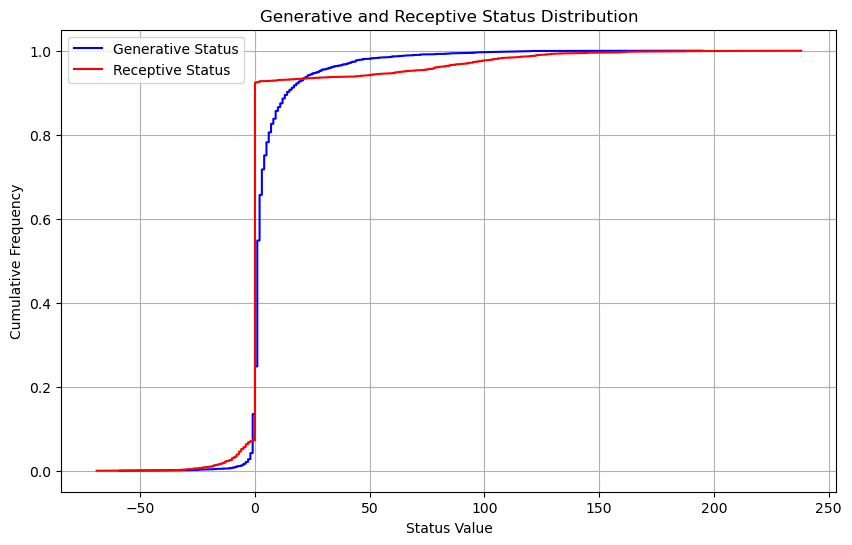

Global Generative Baseline: 0.0
Global Receptive Baseline: 0.0
Node: Steel1943 -> Generative Surprise: 0.0, Receptive Surprise: 0
Node: BDD -> Generative Surprise: 2.0, Receptive Surprise: 105.0
Node: Cuchullain -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: INeverCry -> Generative Surprise: 19.0, Receptive Surprise: 93.0
Node: Cncmaster -> Generative Surprise: 5.0, Receptive Surprise: 0
Node: Miniapolis -> Generative Surprise: 30.0, Receptive Surprise: 60.0
Node: Sven Manguard -> Generative Surprise: 13.0, Receptive Surprise: 10.0
Node: Ramaksoud2000 -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: RockMagnetist -> Generative Surprise: 3.0, Receptive Surprise: 93.0
Node: Carrite -> Generative Surprise: 56.0, Receptive Surprise: 28.0
Node: Someguy1221 -> Generative Surprise: 21.0, Receptive Surprise: 0
Node: Secret -> Generative Surprise: 105.0, Receptive Surprise: 83.0
Node: Dennis Brown -> Generative Surprise: 34.0, Receptive Surprise: 106.0
Node: MJ94 -> Generative

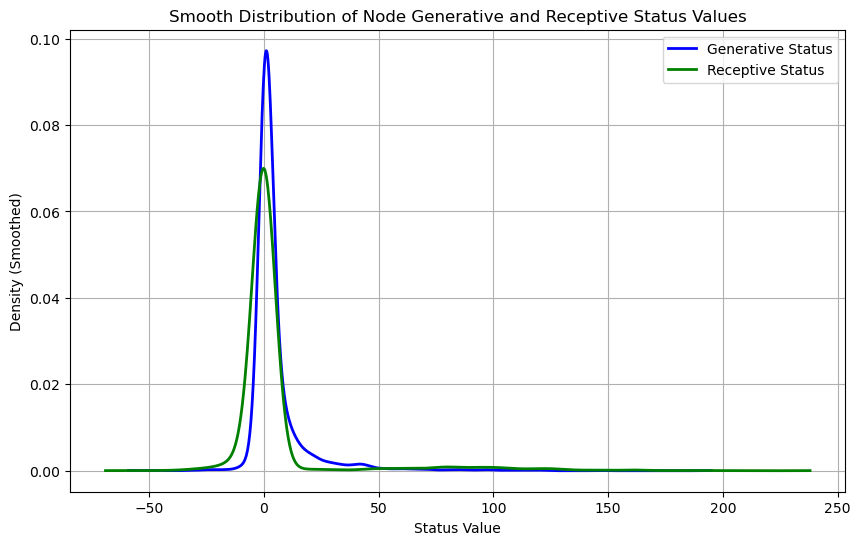

In [43]:
def calculate_status(graph, default_baseline=0.5, negative_threshold=-5):
    """
    Calculate status for each node based on generative and receptive baselines.
    
    :param graph: Directed signed graph with 'weight' attribute (+1/-1/0).
    :param default_baseline: Default value for receptive baseline if the node has no incoming edges.
    :param negative_threshold: The threshold below which receptive surprises are neutralized.
    :return: Dictionary with status information for each node.
    """
    # Step 1: Calculate global generative and receptive baselines
    total_positive_out = 0
    total_out = 0
    total_positive_in = 0
    total_in = 0
    
    for node in graph.nodes():
        out_edges = graph.out_edges(node, data=True)
        in_edges = graph.in_edges(node, data=True)
        
        # Generative baseline: Fraction of positive outgoing edges (excluding neutral edges)
        positive_out = sum(1 for _, _, attr in out_edges if attr.get('weight', 0) > 0)
        total_out += sum(1 for _, _, attr in out_edges if attr.get('weight', 0) != 0)  # Exclude neutral edges
        
        # Receptive baseline: Fraction of positive incoming edges (excluding neutral edges)
        positive_in = sum(1 for _, _, attr in in_edges if attr.get('weight', 0) > 0)
        total_in += sum(1 for _, _, attr in in_edges if attr.get('weight', 0) != 0)  # Exclude neutral edges

    # Global generative and receptive baselines
    generative_baseline = total_positive_out / total_out if total_out > 0 else default_baseline
    receptive_baseline = total_positive_in / total_in if total_in > 0 else default_baseline

    print(f"Global Generative Baseline: {generative_baseline}")
    print(f"Global Receptive Baseline: {receptive_baseline}")

    status = {}

    # Step 2: Compute status for each node
    for node in graph.nodes():
        status[node] = {"generative": 0, "receptive": 0}

        # Outgoing edges: Generative surprise (excluding neutral edges)
        for _, target, attr in graph.out_edges(node, data=True):
            weight = attr.get('weight', 0)
            if weight != 0:  # Ignore neutral edges
                gen_surprise = weight - generative_baseline
                status[node]["generative"] += gen_surprise

        # Incoming edges: Receptive surprise (excluding neutral edges)
        for source, _, attr in graph.in_edges(node, data=True):
            weight = attr.get('weight', 0)
            if weight != 0:  # Ignore neutral edges
                rec_surprise = weight - receptive_baseline

                # If the receptive surprise is below the threshold, treat it as neutral (0)
                if rec_surprise < negative_threshold:
                    rec_surprise = 0  # Neutralize negative surprises

                status[node]["receptive"] += rec_surprise

        # Debugging: Print status for each node
        print(f"Node: {node} -> Generative Surprise: {status[node]['generative']}, Receptive Surprise: {status[node]['receptive']}")

    return status



plot_status_distribution_lines(calculate_status(G, default_baseline=0.5))

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_smooth_binned_status(status):
    """
    Plot the generative and receptive status values separately as smooth curves.
    """
    # Extract generative and receptive status values for each node
    generative_values = [status[node]['generative'] for node in status]
    receptive_values = [status[node]['receptive'] for node in status]
    
    # Define the bin edges (from -75 to 250) with smaller bins (e.g., 50 bins)
    bin_edges = np.linspace(-75, 250, 50)  # 50 bins between -75 and 250
    
    # Plot histogram for generative status values
    plt.figure(figsize=(10, 6))
    
    # Create KDE for generative status values
    kde_gen = gaussian_kde(generative_values, bw_method=0.2)  # Bandwidth parameter for smoothness
    gen_x = np.linspace(min(generative_values), max(generative_values), 1000)
    gen_y = kde_gen(gen_x)
    
    # Create KDE for receptive status values
    kde_rec = gaussian_kde(receptive_values, bw_method=0.2)
    rec_x = np.linspace(min(receptive_values), max(receptive_values), 1000)
    rec_y = kde_rec(rec_x)
    
    # Plot generative and receptive KDEs
    plt.plot(gen_x, gen_y, label='Generative Status', color='blue', linewidth=2)
    plt.plot(rec_x, rec_y, label='Receptive Status', color='green', linewidth=2)
    
    # Customize the plot
    plt.title("Smooth Distribution of Node Generative and Receptive Status Values")
    plt.xlabel("Status Value")
    plt.ylabel("Density (Smoothed)")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_smooth_binned_status(calculate_status(G, default_baseline=0.5))


Global Generative Baseline: 0.0
Global Receptive Baseline: 0.0
Node: Steel1943 -> Generative Surprise: 0.0, Receptive Surprise: 0
Node: BDD -> Generative Surprise: 2.0, Receptive Surprise: 105.0
Node: Cuchullain -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: INeverCry -> Generative Surprise: 19.0, Receptive Surprise: 93.0
Node: Cncmaster -> Generative Surprise: 5.0, Receptive Surprise: 0
Node: Miniapolis -> Generative Surprise: 30.0, Receptive Surprise: 60.0
Node: Sven Manguard -> Generative Surprise: 13.0, Receptive Surprise: 10.0
Node: Ramaksoud2000 -> Generative Surprise: 2.0, Receptive Surprise: 0
Node: RockMagnetist -> Generative Surprise: 3.0, Receptive Surprise: 93.0
Node: Carrite -> Generative Surprise: 56.0, Receptive Surprise: 28.0
Node: Someguy1221 -> Generative Surprise: 21.0, Receptive Surprise: 0
Node: Secret -> Generative Surprise: 105.0, Receptive Surprise: 83.0
Node: Dennis Brown -> Generative Surprise: 34.0, Receptive Surprise: 106.0
Node: MJ94 -> Generative

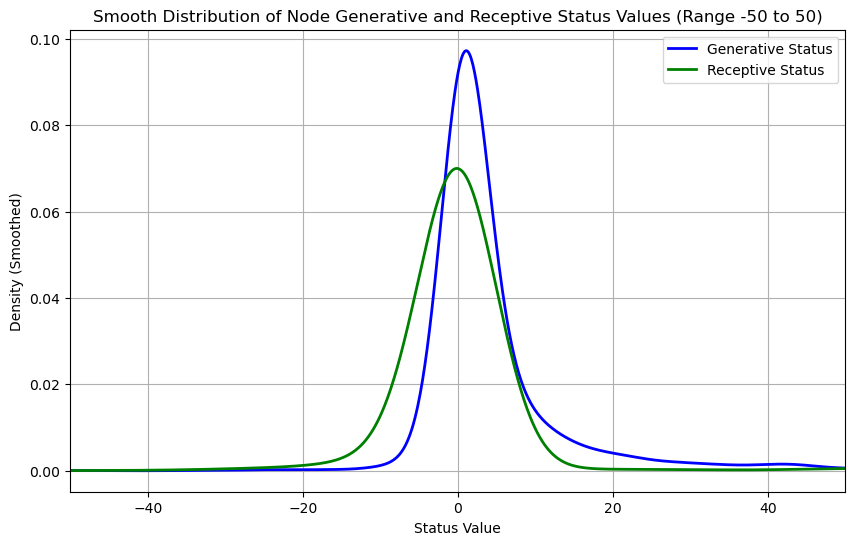

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

def plot_smooth_binned_status(status):
    """
    Plot the generative and receptive status values separately as smooth curves within the range of -50 to 50.
    """
    # Extract generative and receptive status values for each node
    generative_values = [status[node]['generative'] for node in status]
    receptive_values = [status[node]['receptive'] for node in status]
    
    # Define the bin edges (from -50 to 50) with smaller bins (e.g., 50 bins)
    bin_edges = np.linspace(-50, 50, 50)  # 50 bins between -50 and 50
    
    # Plot histogram for generative status values
    plt.figure(figsize=(10, 6))
    
    # Create KDE for generative status values within the range of -50 to 50
    kde_gen = gaussian_kde(generative_values, bw_method=0.2)  # Bandwidth parameter for smoothness
    gen_x = np.linspace(-50, 50, 1000)  # Restrict x-axis to -50 to 50
    gen_y = kde_gen(gen_x)
    
    # Create KDE for receptive status values within the range of -50 to 50
    kde_rec = gaussian_kde(receptive_values, bw_method=0.2)
    rec_x = np.linspace(-50, 50, 1000)  # Restrict x-axis to -50 to 50
    rec_y = kde_rec(rec_x)
    
    # Plot generative and receptive KDEs
    plt.plot(gen_x, gen_y, label='Generative Status', color='blue', linewidth=2)
    plt.plot(rec_x, rec_y, label='Receptive Status', color='green', linewidth=2)
    
    # Customize the plot
    plt.title("Smooth Distribution of Node Generative and Receptive Status Values (Range -50 to 50)")
    plt.xlabel("Status Value")
    plt.ylabel("Density (Smoothed)")
    plt.xlim(-50, 50)  # Set x-axis limit to range between -50 and 50
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

plot_smooth_binned_status(calculate_status(G, default_baseline=0.5))

In [28]:
G = create_signed_graph(df_cleaned)
u, v = 'Steel1943', 'BDD'  # Replace with the nodes of the edge
if G.has_edge(u, v):
    print(f"Attributes for edge ({u}, {v}): {G[u][v]}")
else:
    print(f"No edge exists between {u} and {v}.")

Attributes for edge (Steel1943, BDD): {0: {'weight': 1, 'txt': "'''Support''' as co-nom.", 'admin': 'admin', 'DAT': Timestamp('2013-04-19 23:13:00')}}
